In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("../")
from sklearn.metrics import mean_squared_error
import re

In [2]:
distances_unseen=[2,4,10,20,25,35]
distances_testdata = [1,3,15,30]
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions/'

In [3]:
import numpy as np

In [4]:
regex = re.compile(r'\d+')

In [5]:
%matplotlib inline

In [6]:
from core.utils.data import define_dataset, select_dist

In [7]:
from core.utils.inference import inference_phase_rUNet, inference_phase_rUNet_plot_notebook

In [8]:
from core.models import rUNet

In [9]:
import torch

In [10]:
DATA_DIR_DEEPTHOUGHT = "/storage/yw18581/data"

In [11]:
data_dir = DATA_DIR_DEEPTHOUGHT

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
excluded_testdata = select_dist(dist_list=distances_testdata, root_folder=root_folder)

In [14]:
excluded_testdata

['10x10_1mm_second_clean',
 '10x10_1mm_third_clean',
 '10x10_1mm_first_clean',
 '10x10_3mm_second_clean',
 '10x10_3mm_third_clean',
 '10x10_3mm_first_clean',
 '10x10_15mm_second_clean',
 '10x10_15mm_third_clean',
 '10x10_15mm_first_clean',
 '10x10_30mm_second_clean',
 '10x10_30mm_third_clean',
 '10x10_30mm_first_clean']

In [15]:
excluded_unseen = select_dist(dist_list=distances_unseen, root_folder=root_folder)

In [16]:
excluded_unseen

['10x10_2mm_second_clean',
 '10x10_2mm_third_clean',
 '10x10_2mm_first_clean',
 '10x10_4mm_second_clean',
 '10x10_4mm_third_clean',
 '10x10_4mm_first_clean',
 '10x10_10mm_second_clean',
 '10x10_10mm_third_clean',
 '10x10_10mm_first_clean',
 '10x10_20mm_second_clean',
 '10x10_20mm_third_clean',
 '10x10_20mm_first_clean',
 '10x10_25mm_second_clean',
 '10x10_25mm_third_clean',
 '10x10_25mm_first_clean',
 '10x10_35mm_second_clean',
 '10x10_35mm_third_clean',
 '10x10_35mm_first_clean']

In [17]:
data_loaders_test, data_lengths_test = define_dataset(root_folder, batch_size=16, excluded_list=excluded_testdata, alldata=False)

In [18]:
data_lengths_test

{'train': 3456, 'val': 864, 'test': 1080}

In [19]:
data_loaders_unseen, data_lengths_unseen = define_dataset(root_folder, batch_size=16, excluded_list=excluded_unseen, alldata=True)

In [20]:
data_lengths_unseen

3532

In [21]:
model_names = os.listdir(saved_models)

In [22]:
model_names

['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl',
 'history_Trained_rUNet_pytorch_50epochs_0.75coef.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl',


In [23]:
def get_fnames(key):
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith("Trained"):
            if regex.findall(fname.split("_")[6])[1]==str(key):
                f_list.append(fname)
                epochs.append(int(regex.findall(fname.split("_")[5])[0]))
    return f_list, epochs

In [24]:
get_fnames(25)[0]

['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_60epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_70epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_80epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.25coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_55epochs_

In [25]:
def mse_vs_epochs(coeff, key, data_loaders, data_lengths, only_test=True):
    mse = []
    f_list, epochs = get_fnames(coeff)
    for fname, e in zip(f_list, epochs):
        print(fname, e)
    
        torch.cuda.empty_cache()
        model= rUNet(out_size=1)
        checkpoint = torch.load(os.path.join(saved_models, fname))['model_state_dict'];
        model.load_state_dict(checkpoint)
        y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                               notebook=True, test=only_test)
        np.savez_compressed(os.path.join(saved_models, '_'.join(['predicted',
                                                                 key,
                                                                 fname.split('_')[3],
                                                                 fname.split('_')[5],
                                                                 fname.split('_')[6]])
                                         +'.npz'), true=y_true, pred=y_pred)
        mse.append(mean_squared_error(y_true, y_pred))
        
    plt.plot(epochs, mse)
    return mse, epochs

In [27]:
mse025_test, epochs = mse_vs_epochs(25, 'testdata', data_loaders_test, data_lengths_test)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.25coeff_mask.pkl 5
Trained_rUNet_pytorch_6positions_dataset_45epochs_0.25coeff_mask.pkl 45
Trained_rUNet_pytorch_6positions_dataset_50epochs_0.25coeff_mask.pkl 50
Trained_rUNet_pytorch_6positions_dataset_60epochs_0.25coeff_mask.pkl 60
Trained_rUNet_pytorch_6positions_dataset_70epochs_0.25coeff_mask.pkl 70
Trained_rUNet_pytorch_6positions_dataset_80epochs_0.25coeff_mask.pkl 80
Trained_rUNet_pytorch_6positions_dataset_10epochs_0.25coeff_mask.pkl 10
Trained_rUNet_pytorch_6positions_dataset_15epochs_0.25coeff_mask.pkl 15
Trained_rUNet_pytorch_6positions_dataset_20epochs_0.25coeff_mask.pkl 20
Trained_rUNet_pytorch_6positions_dataset_25epochs_0.25coeff_mask.pkl 25
Trained_rUNet_pytorch_6positions_dataset_30epochs_0.25coeff_mask.pkl 30
Trained_rUNet_pytorch_6positions_dataset_35epochs_0.25coeff_mask.pkl 35
Trained_rUNet_pytorch_6positions_dataset_40epochs_0.25coeff_mask.pkl 40
Trained_rUNet_pytorch_6positions_dataset_55epochs_0.25coeff_mask.p

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30


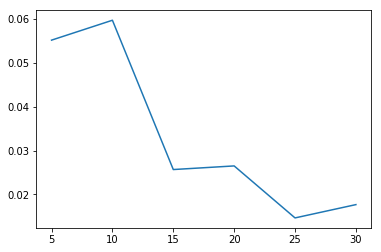

In [66]:
mse030_test, epochs = mse_vs_epochs(3,'testdata',  data_loaders_test, data_lengths_test)

In [ ]:
mse040_test, epochs = mse_vs_epochs(4,'testdata',  data_loaders_test, data_lengths_test)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.5coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.5coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.5coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.5coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.5coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.5coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.5coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.5coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.5coeff_mask.pkl 50



Trained_rUNet_pytorch_6positions_dataset_60epochs_0.5coeff_mask.pkl 60



Trained_rUNet_pytorch_6positions_dataset_70epochs_0.5coeff_mask.pkl 70



Trained_rUNet_pytorch_6positions_dataset_80epochs_0.5coeff_mask.pkl 80



Trained_rUNet_pytorch_6positions_dataset_90epochs_0.5coeff_mask.pkl 90



Trained_rUNet_pytorch_6positions_dataset_100epochs_0.5coeff_mask.pkl 100



Trained_rUNet_pytorch_6positions_dataset_55epochs_0.5coeff_mask.pkl 55



Trained_rUNet_pytorch_6positions_dataset_65epochs_0.5coeff_mask.pkl 65



Trained_rUNet_pytorch_6positions_dataset_75epochs_0.5coeff_mask.pkl 75



Trained_rUNet_pytorch_6positions_dataset_85epochs_0.5coeff_mask.pkl 85



Trained_rUNet_pytorch_6positions_dataset_95epochs_0.5coeff_mask.pkl 95


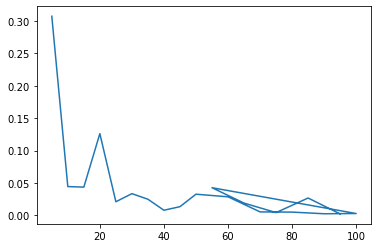

In [58]:
mse050_test, epochs = mse_vs_epochs(5, 'testdata', data_loaders_test, data_lengths_test)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.6coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.6coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.6coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.6coeff_mask.pkl 50



Trained_rUNet_pytorch_6positions_dataset_80epochs_0.6coeff_mask.pkl 80



Trained_rUNet_pytorch_6positions_dataset_90epochs_0.6coeff_mask.pkl 90



Trained_rUNet_pytorch_6positions_dataset_100epochs_0.6coeff_mask.pkl 100



Trained_rUNet_pytorch_6positions_dataset_55epochs_0.6coeff_mask.pkl 55



Trained_rUNet_pytorch_6positions_dataset_60epochs_0.6coeff_mask.pkl 60



Trained_rUNet_pytorch_6positions_dataset_65epochs_0.6coeff_mask.pkl 65



Trained_rUNet_pytorch_6positions_dataset_70epochs_0.6coeff_mask.pkl 70



Trained_rUNet_pytorch_6positions_dataset_75epochs_0.6coeff_mask.pkl 75



Trained_rUNet_pytorch_6positions_dataset_85epochs_0.6coeff_mask.pkl 85



Trained_rUNet_pytorch_6positions_dataset_95epochs_0.6coeff_mask.pkl 95


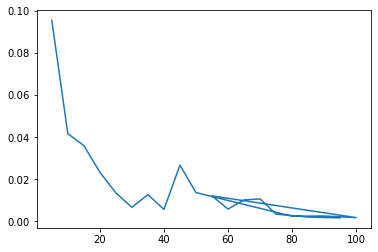

In [60]:
mse060_test, epochs = mse_vs_epochs(6, 'testdata', data_loaders_test, data_lengths_test)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.7coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.7coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.7coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.7coeff_mask.pkl 50



Trained_rUNet_pytorch_6positions_dataset_55epochs_0.7coeff_mask.pkl 55



Trained_rUNet_pytorch_6positions_dataset_60epochs_0.7coeff_mask.pkl 60



Trained_rUNet_pytorch_6positions_dataset_65epochs_0.7coeff_mask.pkl 65



Trained_rUNet_pytorch_6positions_dataset_70epochs_0.7coeff_mask.pkl 70



Trained_rUNet_pytorch_6positions_dataset_75epochs_0.7coeff_mask.pkl 75



Trained_rUNet_pytorch_6positions_dataset_80epochs_0.7coeff_mask.pkl 80



Trained_rUNet_pytorch_6positions_dataset_85epochs_0.7coeff_mask.pkl 85



Trained_rUNet_pytorch_6positions_dataset_90epochs_0.7coeff_mask.pkl 90



Trained_rUNet_pytorch_6positions_dataset_95epochs_0.7coeff_mask.pkl 95



Trained_rUNet_pytorch_6positions_dataset_100epochs_0.7coeff_mask.pkl 100


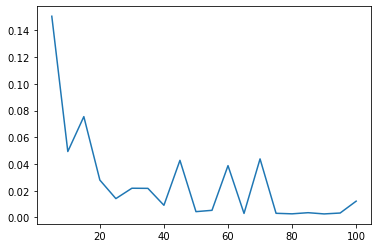

In [62]:
mse070_test, epochs = mse_vs_epochs(7, 'testdata', data_loaders_test, data_lengths_test)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl 50



Trained_rUNet_pytorch_6positions_dataset_55epochs_0.75coeff_mask.pkl 55



Trained_rUNet_pytorch_6positions_dataset_60epochs_0.75coeff_mask.pkl 60



Trained_rUNet_pytorch_6positions_dataset_65epochs_0.75coeff_mask.pkl 65



Trained_rUNet_pytorch_6positions_dataset_70epochs_0.75coeff_mask.pkl 70



Trained_rUNet_pytorch_6positions_dataset_75epochs_0.75coeff_mask.pkl 75



Trained_rUNet_pytorch_6positions_dataset_80epochs_0.75coeff_mask.pkl 80



Trained_rUNet_pytorch_6positions_dataset_85epochs_0.75coeff_mask.pkl 85



Trained_rUNet_pytorch_6positions_dataset_90epochs_0.75coeff_mask.pkl 90



Trained_rUNet_pytorch_6positions_dataset_95epochs_0.75coeff_mask.pkl 95



Trained_rUNet_pytorch_6positions_dataset_100epochs_0.75coeff_mask.pkl 100


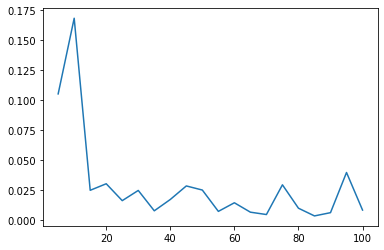

In [64]:
mse075_test, epochs = mse_vs_epochs(75, 'testdata', data_loaders_test, data_lengths_test)

In [ ]:
mse025_unseen, epochs = mse_vs_epochs(25, 'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

In [ ]:
mse030_unseen, epochs = mse_vs_epochs(3,'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

In [ ]:
mse040_unseen, epochs = mse_vs_epochs(4,'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

In [ ]:
mse050_unseen, epochs = mse_vs_epochs(5, 'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

In [ ]:
mse060_unseen, epochs = mse_vs_epochs(6, 'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30



Trained_rUNet_pytorch_6positions_dataset_35epochs_0.6coeff_mask.pkl 35



Trained_rUNet_pytorch_6positions_dataset_40epochs_0.6coeff_mask.pkl 40



Trained_rUNet_pytorch_6positions_dataset_45epochs_0.6coeff_mask.pkl 45



Trained_rUNet_pytorch_6positions_dataset_50epochs_0.6coeff_mask.pkl 50



Trained_rUNet_pytorch_6positions_dataset_80epochs_0.6coeff_mask.pkl 80



Trained_rUNet_pytorch_6positions_dataset_90epochs_0.6coeff_mask.pkl 90



Trained_rUNet_pytorch_6positions_dataset_100epochs_0.6coeff_mask.pkl 100



Trained_rUNet_pytorch_6positions_dataset_55epochs_0.6coeff_mask.pkl 55



Trained_rUNet_pytorch_6positions_dataset_60epochs_0.6coeff_mask.pkl 60



Trained_rUNet_pytorch_6positions_dataset_65epochs_0.6coeff_mask.pkl 65



Trained_rUNet_pytorch_6positions_dataset_70epochs_0.6coeff_mask.pkl 70



Trained_rUNet_pytorch_6positions_dataset_75epochs_0.6coeff_mask.pkl 75



Trained_rUNet_pytorch_6positions_dataset_85epochs_0.6coeff_mask.pkl 85



Trained_rUNet_pytorch_6positions_dataset_95epochs_0.6coeff_mask.pkl 95


In [ ]:
mse070_unseen, epochs = mse_vs_epochs(7, 'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)

In [ ]:
mse075_unseen, epochs = mse_vs_epochs(75, 'unseen', data_loaders_unseen, data_lengths_unseen, only_test=False)